In [1]:
# importing the required libaries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('framingham.csv')
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
# 13% of the data contains nan values.
df = df.fillna(df.mean())
df.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [4]:
df.shape

(4238, 16)

In [5]:
# creating X and y
X_ = df.drop(columns='TenYearCHD', axis=1).copy(deep=True)
y = df['TenYearCHD'].copy(deep=True)



# Identify the features with the most importance for the outcome variable Heart Disease
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2



# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_.columns)



featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores.nlargest(11,'Score') 



featureScores = featureScores.sort_values(by='Score', ascending=False)
featureScores.reset_index()

,index,Specs,Score
0,10,sysBP,728.292522
1,14,glucose,390.825416
2,1,age,318.597444
3,9,totChol,234.305978
4,4,cigsPerDay,221.677041
5,11,diaBP,153.090954
6,7,prevalentHyp,92.167857
7,8,diabetes,39.103710
8,5,BPMeds,30.578341
9,0,male,18.915212


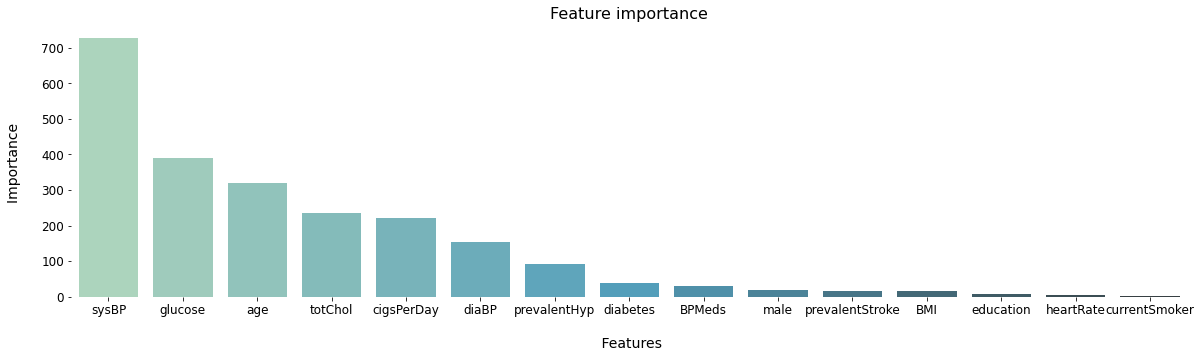

In [6]:
# visualizing feature selection
plt.figure(figsize=(20,5))
sns.barplot(x='Specs', y='Score', data=featureScores, palette = "GnBu_d")
plt.box(False)
plt.title('Feature importance', fontsize=16)
plt.xlabel('\n Features', fontsize=14)
plt.ylabel('Importance \n', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [7]:
X_ = X_.drop(columns=['prevalentStroke', 'BMI', 'education', 'heartRate', 'currentSmoker'], axis=1).values

In [8]:
# Importing StandardScaler
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X_)

# train test validation split
from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# validation split from X_full
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=1)


# Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', max_iter=3000)

# fit and predict
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)

# accuracy % check
from sklearn import metrics
from sklearn.metrics import accuracy_score
m1 = metrics.accuracy_score(y_pred_test, y_test)
print(m1)

0.8620283018867925


In [9]:
# Importing Confusion matrix and accuracy score to evaluate the performance of the model
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_test)

array([[725,   8],
       [109,   6]], dtype=int64)

In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       733
           1       0.43      0.05      0.09       115

    accuracy                           0.86       848
   macro avg       0.65      0.52      0.51       848
weighted avg       0.81      0.86      0.81       848



In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# loop to find the best threshold
y_pred_prob = logreg.predict_proba(X_val)
print('Logistic test roc-auc: {}'.format(roc_auc_score(y_test, y_pred_prob[:,1])))

Logistic test roc-auc: 0.5042529212883325


In [12]:
pred=[]
for model in [logreg]:
    pred.append(pd.Series(model.predict_proba(X_val)[:,1]))
final_prediction=pd.concat(pred,axis=1).mean(axis=1)
print('Ensemble test roc-auc: {}'.format(roc_auc_score(y_val,final_prediction)))



pd.concat(pred,axis=1)


#### Calculate the ROc Curve
fpr, tpr, thresholds = roc_curve(y_val, final_prediction)

Ensemble test roc-auc: 0.7263300222513228


In [13]:
from sklearn.metrics import accuracy_score
accuracy_ls = []
for thres in thresholds:
    y_pred_test = np.where(final_prediction>thres,1,0)
    accuracy_ls.append(accuracy_score(y_test, y_pred_test, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()

,thresholds,accuracy
0,1.941908,0.864387
1,0.941908,0.864387
2,0.648019,0.859670
3,0.643823,0.858491
4,0.609729,0.853774


In [29]:
# changing threshold
y_pred_new_threshold = (logreg.predict_proba(X_test)[:,1]>=1.941908	).astype(int)
metrics.accuracy_score(y_pred_new_threshold, y_test)

0.8643867924528302

In [30]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

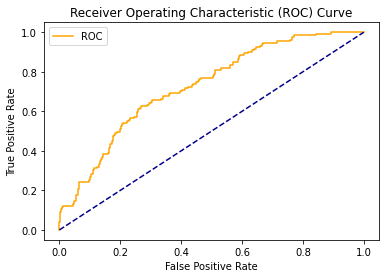

In [31]:
plot_roc_curve(fpr,tpr)

In [34]:
# predicting on validation dataset
y_pred_val = logreg.predict(X_val)
m2 = metrics.accuracy_score(y_pred_val, y_val)
print(m2)

0.8525943396226415


In [33]:
y_val.value_counts(normalize=True)

0    0.845519
1    0.154481
Name: TenYearCHD, dtype: float64